In [8]:
### 1. 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [9]:
### 2. 데이터 로드 및 시퀀스 구성 함수
def load_csv_and_make_sequences(csv_path, seq_length=30):
    """
    CSV 파일에서 프레임별 포즈 데이터를 읽고, 결측치 제거 후,
    seq_length만큼 슬라이딩 윈도우로 시퀀스를 구성하여 반환.
    첫 열('frame')을 제외하고 (프레임 수, 132) 데이터를 얻는다고 가정.
    """
    df = pd.read_csv(csv_path)
    df = df.dropna()  # 결측치 제거

    # 첫 열('frame') 제외 -> 랜드마크 33개 × 4개 값 = 132
    data = df.iloc[:, 1:].values  # shape: (프레임 수, 132)
    n_frames = data.shape[0]

    sequences = []
    for i in range(n_frames - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)

    return np.array(sequences)  # (n_seq, seq_length, 132) 형태

def load_multiple_csvs(csv_dir, file_prefix="pose_data", start_num=1, end_num=10, seq_length=30):
    """
    예: pose_data1.csv ~ pose_data10.csv까지 로드하여 하나로 합치는 함수.
    """
    all_seqs = []
    for i in range(start_num, end_num + 1):
        csv_path = os.path.join(csv_dir, f"{file_prefix}{i}.csv")
        if os.path.exists(csv_path):
            seqs = load_csv_and_make_sequences(csv_path, seq_length)
            all_seqs.append(seqs)
            print(f"[INFO] Loaded: {csv_path}, shape={seqs.shape}")
        else:
            print(f"[WARNING] File not found: {csv_path}, skipping...")

    if len(all_seqs) == 0:
        print("[ERROR] No CSV files loaded. Check paths and file names.")
        return None

    # 여러 CSV 시퀀스를 하나로 합침
    X = np.concatenate(all_seqs, axis=0)
    return X


In [10]:
### 3. LSTM Autoencoder 모델 정의
def build_lstm_autoencoder(timesteps, n_features, latent_dim=64):
    """
    LSTM Autoencoder 구성.
    입력: (timesteps, n_features)
    출력: 동일 크기 (timesteps, n_features)
    """
    inputs = Input(shape=(timesteps, n_features))
    # 인코더
    encoded = LSTM(latent_dim)(inputs)
    encoded = RepeatVector(timesteps)(encoded)

    # 디코더
    decoded = LSTM(latent_dim, return_sequences=True)(encoded)
    outputs = TimeDistributed(Dense(n_features))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [11]:
### 4. 정상 데이터 로드 & Autoencoder 학습
### 4.1. 정상 데이터 로드
csv_directory = r"C:\barunrun\pose_data"  # 실제 폴더 경로
X_expert = load_multiple_csvs(
    csv_dir=csv_directory,
    file_prefix="pose_data",  # pose_data1.csv ~ pose_data10.csv
    start_num=1,
    end_num=10,
    seq_length=30
)

if X_expert is None:
    raise ValueError("No expert data loaded. Check CSV paths.")

print("X_expert shape:", X_expert.shape)  # 예: (N, 30, 132)

### 4.2. 모델 빌드
timesteps = 30
n_features = X_expert.shape[2]  # 보통 132 (33×4)
latent_dim = 64

autoencoder = build_lstm_autoencoder(timesteps, n_features, latent_dim)
autoencoder.summary()

### 4.3. 모델 학습
# Autoencoder는 입력=X_expert, 출력=X_expert
history = autoencoder.fit(
    X_expert, X_expert,
    epochs=20,
    batch_size=16,
    validation_split=0.1  # 10%를 검증용
)


[INFO] Loaded: C:\barunrun\pose_data\pose_data1.csv, shape=(545, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data2.csv, shape=(233, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data3.csv, shape=(286, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data4.csv, shape=(170, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data5.csv, shape=(518, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data6.csv, shape=(308, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data7.csv, shape=(282, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data8.csv, shape=(211, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data9.csv, shape=(381, 30, 132)
[INFO] Loaded: C:\barunrun\pose_data\pose_data10.csv, shape=(238, 30, 132)
X_expert shape: (3172, 30, 132)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 132)        │         8,580 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,036 (359.52 KB)

 Trainable params: 92,036 (359.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0927 - val_loss: 0.0175
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0111 - val_loss: 0.0144
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0091 - val_loss: 0.0119
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0075 - val_loss: 0.0096
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0072 - val_loss: 0.0096
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0071 - val_loss: 0.0094
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[INFO] 전문가 데이터 개수: 3172
평균 MSE: 0.006622, 표준편차: 0.004630
임계값(Threshold): 0.020512


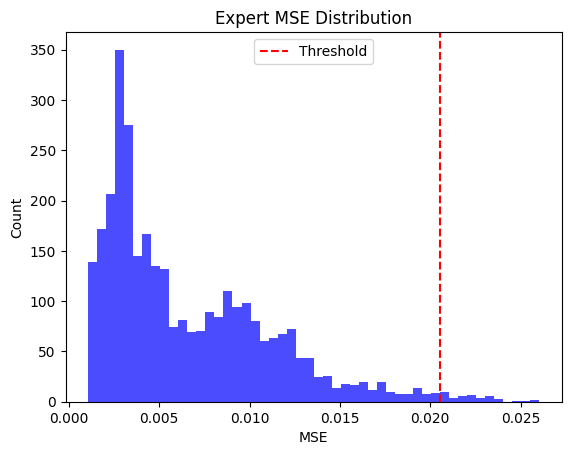

In [12]:
### 5. 전문가(정상) 데이터 복원 오차 & 임계값
import matplotlib.pyplot as plt

# 학습 후, 전문가 데이터 복원
X_expert_pred = autoencoder.predict(X_expert)
mse_expert = np.mean((X_expert - X_expert_pred)**2, axis=(1,2))

mean_mse_expert = np.mean(mse_expert)
std_mse_expert = np.std(mse_expert)
threshold = mean_mse_expert + 3 * std_mse_expert  # 예시로 평균+3*표준편차

print(f"[INFO] 전문가 데이터 개수: {len(mse_expert)}")
print(f"평균 MSE: {mean_mse_expert:.6f}, 표준편차: {std_mse_expert:.6f}")
print(f"임계값(Threshold): {threshold:.6f}")

# MSE 분포 시각화 (옵션)
plt.hist(mse_expert, bins=50, alpha=0.7, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Expert MSE Distribution")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.show()


X_abnormal shape: (381, 30, 132)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

===== 비정상 데이터 예측 결과 =====
총 381개 시퀀스 중, 임계값 초과(이상치): 28
비정상 판단 비율: 0.073
임계값: 0.020512
전문가 데이터 평균 MSE: 0.006622, 표준편차: 0.004630


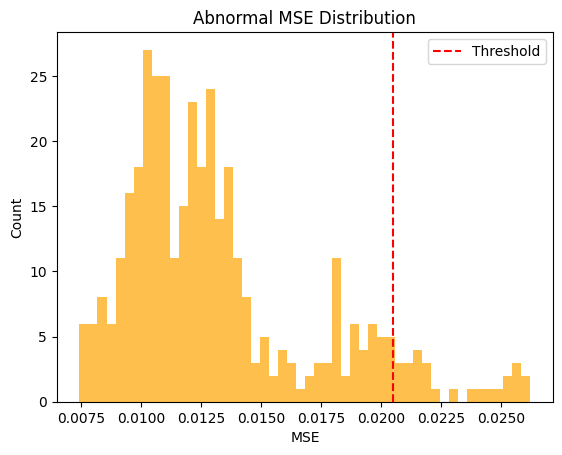

In [13]:
### 6. 비정상 데이터 로드 & 이상 여부 판단
### 6.1. 비정상 CSV 로드
csv_path_abnormal = r"C:\barunrun\pose_data\pose_data_abnormal1.csv"
X_abnormal = load_csv_and_make_sequences(csv_path_abnormal, seq_length=30)
print("X_abnormal shape:", X_abnormal.shape)

### 6.2. 복원 & MSE 계산
X_abnormal_pred = autoencoder.predict(X_abnormal)
mse_abnormal = np.mean((X_abnormal - X_abnormal_pred)**2, axis=(1,2))

### 6.3. 이상치 판정
abnormal_detected = np.sum(mse_abnormal > threshold)
abnormal_ratio = abnormal_detected / len(mse_abnormal)

print("\n===== 비정상 데이터 예측 결과 =====")
print(f"총 {len(mse_abnormal)}개 시퀀스 중, 임계값 초과(이상치): {abnormal_detected}")
print(f"비정상 판단 비율: {abnormal_ratio:.3f}")
print(f"임계값: {threshold:.6f}")
print(f"전문가 데이터 평균 MSE: {mean_mse_expert:.6f}, 표준편차: {std_mse_expert:.6f}")

# (옵션) 비정상 MSE 히스토그램도 볼 수 있음
plt.hist(mse_abnormal, bins=50, alpha=0.7, color='orange')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Abnormal MSE Distribution")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.show()


In [14]:
### 7. (옵션) 모델 저장 & 로드
# 모델 저장
autoencoder.save("lstm_autoencoder_model.h5")
print("[INFO] 모델 저장 완료.")

# 이후 다른 셀이나 다른 노트북에서 로드
# from tensorflow.keras.models import load_model
# autoencoder_loaded = load_model("lstm_autoencoder_model.h5")
# mse_abnormal_new = autoencoder_loaded.predict(X_abnormal)


[INFO] 모델 저장 완료.


 ### 이 노트북 예시를 순서대로 실행하면:

- 정상 CSV(10개) 로드 → 시퀀스 구성 → 합침   
- LSTM Autoencoder 빌드 & 학습 → 정상 패턴 복원 능력 습득   
- 학습된 모델로 정상 데이터 MSE를 구해 임계값 설정   
- 비정상 CSV 로드 → 복원 오차 계산 → 임계값 초과 여부로 이상치 판정   

이렇게 단계별로 전 과정을 한 번에 수행할 수 있습니다.   
경로, 파일명, 시퀀스 길이, latent_dim, 에폭 수 등은 상황에 맞게 조정하시고,   
실행 시 나오는 로그(에폭별 loss)와 결과(MSE 분포)를 확인해 가며 튜닝을 진행하세요.   

### 현재 실행 결과를 보면,
- 정상 데이터 분포는 평균 MSE가 약 0.0066, 표준편차가 약 0.0046이며,   
- 임계값(Threshold)은 약 0.0205 정도로 설정되었고,   
- 비정상 데이터 381개 중 28개(약 7.3%)만 임계값을 초과(“이상치”)로 판정되었습니다.   

즉, 비정상 데이터의 대부분(92.7%)이 정상 범위 안에 포함되어, 모델이 “비정상”을 제대로 잡아내지 못하고 있습니다.   

이런 결과가 나오는 이유와 개선 방안을 정리해 드리겠습니다.   
   
### 1. 결과 해석   
1. 정상 데이터 MSE 분포   
    - 히스토그램 상으로 0~0.02 구간에 대부분 몰려 있고, 일부 꼬리가 0.03 근처까지 이어집니다.   
    - 평균(0.0066)에 비해 임계값(0.0205)이 꽤 높게 설정된 편이라, 정상 데이터 중 상당수(대부분)는 임계값 아래에 있습니다.   

2. 비정상 데이터 MSE 분포   
    - 그래프를 보면 비정상 데이터 역시 0~0.015 근처에 많이 분포하고 있어,   
    - 실제로 정상 분포와 크게 겹치는 부분이 많기 때문에, 오차가 임계값 이하로 나온 시퀀스가 많습니다(= 비정상인데 정상으로 판단).   

3. 7.3%만 이상치   
    - 결국 비정상 시퀀스 중 소수(28개)만 임계값을 초과하여 이상치로 분류되고,   
    - 나머지(약 92.7%)는 정상 범위 안에 들어왔다는 뜻입니다.   
   
### 2. 왜 이런 결과가 나올까?   
1.  비정상 데이터가 실제로 정상과 크게 다르지 않을 수도 있음   
    - 러닝 자세가 “조금만” 비정상이라면, Autoencoder가 복원할 때 큰 오차가 안 날 수 있습니다.   

2. 데이터 양의 부족      
    - 정상 10개 영상 + 비정상 1개 영상만으로는 모델이 러닝 동작의 “정상/비정상” 차이를 학습하기에 충분치 않을 수 있습니다.   
    - 비정상 데이터가 더 다양하거나 많아야, 정상과 구별되는 특징이 뚜렷해질 가능성이 높습니다.   

3. 모델/하이퍼파라미터 제한   
    - Autoencoder 구조(레이어 수, latent_dim=64), 학습 에폭(20번) 등으로는 복잡한 차이를 학습하기 부족할 수 있습니다.   
    - 더 깊은 모델이나 더 많은 에폭, 다른 구조(예: Transformer Autoencoder) 등을 시도할 수 있습니다.   

4. 임계값(Threshold) 설정   
    - 현재는 평균 + 3*표준편차로 임계값을 정했습니다.   
    - 만약 비정상을 더 많이 잡고 싶다면, 임계값을 좀 더 낮추거나 다른 방식(중앙값+IQR 등)을 시도할 수 있습니다.   
    - 다만, 임계값을 낮추면 정상 데이터 일부도 이상치로 잡힐 수 있으므로, 그 균형을 맞춰야 합니다.   
   
### 3. 개선 방향   
1. 데이터 확충   
    - 비정상 영상을 더 많이, 다양한 형태(속도, 착지, 자세 등)로 확보하면,   
    모델이 “정상과 다른 패턴”을 잘 학습하거나(지도학습), Autoencoder 기준으로 더 큰 오차를 내도록 만들 수 있습니다.   
    - 정상 영상도 속도·체형·환경이 다양한 데이터를 모으는 게 좋습니다.   

2. Autoencoder 구조/학습 개선
    - 더 많은 LSTM 레이어를 쌓거나, latent_dim을 늘려 모델 용량을 키울 수 있습니다.   
    - 학습 에폭을 늘리거나, Early Stopping을 도입해 오버피팅을 방지하면서 충분히 학습할 수도 있습니다.   
    - Transformer 기반 시계열 Autoencoder도 시도해 볼 수 있습니다.   

3. 임계값 조정   
    - 지금은 “평균 + 3×표준편차”로 했는데, 이보다 낮게(예: 2.5×) 설정하면 비정상 검출이 조금 늘어날 수 있습니다.   
    - 정상 데이터 중 일부가 이상치가 될 수도 있으니, 그 비율도 함께 모니터링해야 합니다.   

4. 특정 관절만 사용 / 특징 공학   
    - 무릎, 엉덩이, 발목 등 “러닝 자세”에 특히 중요한 관절만 추출하면, 비정상일 때 더 큰 차이가 날 수도 있습니다.   
    - 또는 PCA/차원 축소로 잡음을 줄이고, 오히려 더 뚜렷한 차이를 얻을 수도 있습니다.   

### 4. 결론
- 현재 결과(비정상 7.3% 검출)가 “원하는 만큼 비정상을 구분하지 못한다”고 느껴지면, 데이터 확충과 모델/임계값 튜닝이 필요합니다.   
- 데이터가 많지 않고 비정상 영상도 다양하지 않으면, Autoencoder가 정상·비정상을 충분히 구별하기 어렵습니다.   
- 장기적으로 더 많은 비정상 영상을 확보하고, Autoencoder 구조나 파라미터를 다양하게 시도해보면 성능이 향상될 수 있습니다.   

따라서, “정말 데이터가 적어서 생기는 문제”일 가능성이 크고, 모델 자체가 정상·비정상을 완전히 분리할 정도로 학습하지 못한 것으로 해석할 수 있습니다.   
지금 상황이 “완전히 잘못된” 것은 아니며, 데이터나 하이퍼파라미터가 한정된 상태에서 나올 수 있는 자연스러운 결과라고 보시면 됩니다.   